# Finding Similar Songs on Spotify - Part 3 - Siamese Networks with Tag Similarity

In this tutorial I will demonstrate how to apply machine learning to search for similar songs on Spotify.

## Tutorial Overview

1. Loading data
2. Preprocess data
3. Define Model
4. Fit Model
5. Evaluate Model



## Requiremnts

Install the following dependencies to run this tutorial:

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf

In [2]:
# visualization
%matplotlib inline

import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

# numeric and scientific processing
import numpy as np
import pandas as pd

from scipy.spatial.distance import dice, pdist, squareform

# misc
import os
import progressbar

from IPython.display import HTML, display

pd.set_option('display.max_colwidth', -1)

# Loading Data

We will use the same data that we downloaded from Spotify in Part 1 of the Tutorial. Because we used the joblib library, we will not have to wait that long, because the data is already cached on our harddrive.

In [4]:
DATASET_PATH    = "D:/Research/Data/MIR/MagnaTagATune"

AUTIO_ROOT_PATH = "%s/mp3_full" % DATASET_PATH

## Load Feature Data

In [5]:
with np.load("%s/ISMIR2018_tut_Magnagtagatune_spectrograms.npz" % DATASET_PATH) as npz:
    melspecs      = npz["features"]
    clip_id       = npz["clip_id"]
    
melspecs.shape

(6380, 80, 80)

## Load Metadata

In [6]:
metadata = pd.read_csv("./metadata/ismir2018_tut_part_3_similartiy_metadata.csv", index_col=0)

Align featuredata with metadata

In [7]:
feature_metadata = pd.DataFrame(np.arange(melspecs.shape[0]), 
                                columns = ["featurespace_id"])

feature_metadata["clip_id"] = clip_id

In [8]:
metadata = metadata.reset_index()
metadata = metadata.merge(feature_metadata, left_on="clip_id", right_on="clip_id", how="inner", left_index=True, right_index=False)
metadata = metadata.set_index("index")

Sort Metadata by Feature-space ID => metadata is aligned to feature-data

In [9]:
metadata.sort_values("featurespace_id", inplace=True)

Select feature-data for this metadata

In [10]:
melspecs = melspecs[metadata.featurespace_id].astype(np.float32)

In [11]:
melspecs = np.expand_dims(melspecs, 3)

In [12]:
metadata["featurespace_id"] = np.arange(metadata.shape[0])

In [13]:
tmp                = metadata.mp3_path.str.split("/", expand=True)
metadata["player"] = '<audio src="http://localhost:9999/' + tmp[6] + '/' + tmp[7] +'" controls>'

## Load Labels

In [14]:
labels = pd.read_csv("./metadata/ismir2018_tut_part_3_similarity_labels.csv", index_col=0)

In [15]:
labels.shape

(2943, 135)

In [16]:
labels = labels.loc[metadata.index]

# Tag Similarities

Tag similarity refers to the semantic relationship between two labels. In the context of this tutorial we are talking about genre labels. These are provided by the Spotify API for each artist. This is not as precise as for each track, but we take what we get. We still need to consider that an artist might change its artistic orientation which means he can cross or change its genre or on the other hand, the genre can change itself (e.g. Rhythm and Blues). Most of all, we should keep in mind that the concept of music genre is highly subjective and its interpretation might vary between the annotators who labelled the provided tracks.

So this is how the labels look like:

In [17]:
metadata.head()

,clip_id,mp3_path,track_number,title,artist,album,url,segmentStart,segmentEnd,original_url,featurespace_id,player
index,,,,,,,,,,,,
29,66,D:/Research/Data/MIR/MagnaTagATune/mp3_full/9/american_bach_soloists-heinrich_schutz__musicalische_exequien-01-musicalische_exequien_swv_279_teil_i_concert_in_form_einer_teutschen_begrabnismissa-784-813.mp3,1,Musicalische Exequien SWV 279 Teil I_ Concert in Form einer teutschen Begrabnis-Missa,American Bach Soloists,Heinrich Schutz - Musicalische Exequien,http://www.magnatune.com/artists/albums/abs-heinrich/,784,813,http://he3.magnatune.com/all/01--Musicalische%20Exequien%20SWV%20279%20Teil%20I_%20Concert%20in%20Form%20einer%20teutschen%20Begrabnis-Missa--ABS.mp3,0,"<audio src=""http://localhost:9999/9/american_bach_soloists-heinrich_schutz__musicalische_exequien-01-musicalische_exequien_swv_279_teil_i_concert_in_form_einer_teutschen_begrabnismissa-784-813.mp3"" controls>"
43,90,D:/Research/Data/MIR/MagnaTagATune/mp3_full/6/ralph_meulenbroeks-gambomania-01-my_mistress_hath_a_pritty_thing_tobias_hume-59-88.mp3,1,My mistress hath a pritty thing (Tobias Hume),Ralph Meulenbroeks,Gambomania,http://www.magnatune.com/artists/albums/meulenbroeks-gambomania/,59,88,http://he3.magnatune.com/all/01--My%20mistress%20hath%20a%20pritty%20thing%20(Tobias%20Hume)--Ralph%20Meulenbroeks.mp3,1,"<audio src=""http://localhost:9999/6/ralph_meulenbroeks-gambomania-01-my_mistress_hath_a_pritty_thing_tobias_hume-59-88.mp3"" controls>"
44,91,D:/Research/Data/MIR/MagnaTagATune/mp3_full/6/ralph_meulenbroeks-gambomania-01-my_mistress_hath_a_pritty_thing_tobias_hume-88-117.mp3,1,My mistress hath a pritty thing (Tobias Hume),Ralph Meulenbroeks,Gambomania,http://www.magnatune.com/artists/albums/meulenbroeks-gambomania/,88,117,http://he3.magnatune.com/all/01--My%20mistress%20hath%20a%20pritty%20thing%20(Tobias%20Hume)--Ralph%20Meulenbroeks.mp3,2,"<audio src=""http://localhost:9999/6/ralph_meulenbroeks-gambomania-01-my_mistress_hath_a_pritty_thing_tobias_hume-88-117.mp3"" controls>"
46,94,D:/Research/Data/MIR/MagnaTagATune/mp3_full/6/ralph_meulenbroeks-gambomania-01-my_mistress_hath_a_pritty_thing_tobias_hume-175-204.mp3,1,My mistress hath a pritty thing (Tobias Hume),Ralph Meulenbroeks,Gambomania,http://www.magnatune.com/artists/albums/meulenbroeks-gambomania/,175,204,http://he3.magnatune.com/all/01--My%20mistress%20hath%20a%20pritty%20thing%20(Tobias%20Hume)--Ralph%20Meulenbroeks.mp3,3,"<audio src=""http://localhost:9999/6/ralph_meulenbroeks-gambomania-01-my_mistress_hath_a_pritty_thing_tobias_hume-175-204.mp3"" controls>"
51,105,D:/Research/Data/MIR/MagnaTagATune/mp3_full/0/rocket_city_riot-last_of_the_pleasure_seekers-01-under_the_bright_lights-146-175.mp3,1,Under The Bright Lights,Rocket City Riot,Last Of The Pleasure Seekers,http://www.magnatune.com/artists/albums/rocketcity-pleasure/,146,175,http://he3.magnatune.com/all/01--Under%20The%20Bright%20Lights--Rocket%20City%20Riot.mp3,4,"<audio src=""http://localhost:9999/0/rocket_city_riot-last_of_the_pleasure_seekers-01-under_the_bright_lights-146-175.mp3"" controls>"


In [18]:
idx = 1

print("Track : " + " - ".join(metadata[["artist", "title"]].iloc[idx]) )
print("Labels: '" + "', '".join(labels.columns[labels.iloc[idx] == 1]) + "'")

Track : Ralph Meulenbroeks - My mistress hath a pritty thing (Tobias Hume)
Labels: 'solo', 'viola', 'cello', 'classical', 'fast', 'string', 'violin'


### Calculating similarities between Tracks based on labels

To estimate the similarities between tracks, we first have to assess, how many labels  we have and how they are distributed.

### Term (Label) Frequencies

As a next step we will analyze how many labels we have in our dataset, which ones are the most frequently used and so on.

So let's see what are the most used genre labels in our dataset:

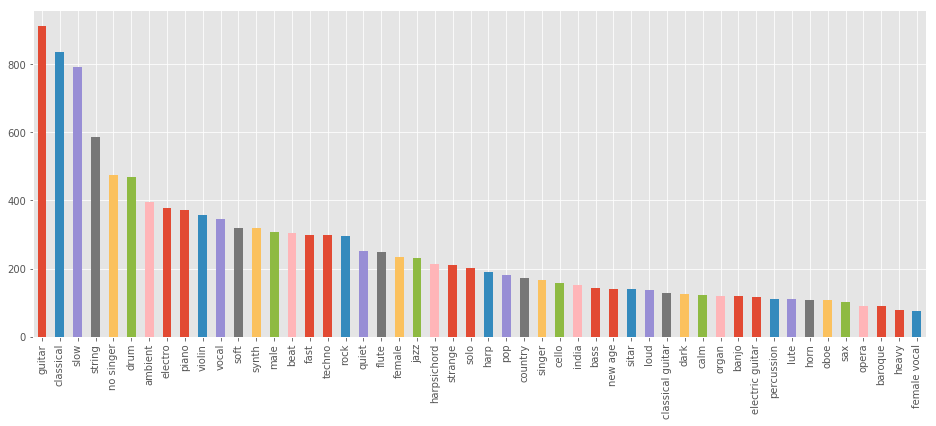

In [19]:
labels.sum(axis=0).sort_values(ascending=False)[:50].plot(kind="bar", figsize=(16,6));

As we can see, the "rock" genre is the most dominating one. Thus, providing this label to a track does not add more relevant information to it to distinguish it from other tracks. The term "romantic" on the other hand is less frequent which makes it more discrimitative.

In [20]:
tf            = labels.sum(axis=0)
idf           = np.log(labels.shape[0] / tf)
labels_tf_idf = labels / idf

Based on this rescaled label weights, we can calculate the tag-based similarties between all pairs of tracks. We will use the Dice metric

In [21]:
# the pdist function calculates all pairwise distances
dists = pdist(labels_tf_idf, 'dice')

# pdist returns a list of results. We use the squareform function to convert this into a symmetric matrix
tag_based_track_similarities = pd.DataFrame((1 - squareform(dists)), 
                                            index   = labels_tf_idf.index,
                                            columns = labels_tf_idf.index)

Now we can use this to search for similar tracks using the tag-similarities:

In [22]:
tag_based_track_similarities.iloc[:10,:10]

index,29,43,44,46,51,79,93,105,107,109
index,,,,,,,,,,
29,1.000000,0.153846,0.200000,0.166667,0.000000,0.222222,0.190476,0.181818,0.000000,0.000000
43,0.153846,1.000000,0.727273,0.615385,0.181818,0.600000,0.090909,0.166667,0.000000,0.000000
44,0.200000,0.727273,1.000000,0.800000,0.000000,0.857143,0.000000,0.222222,0.000000,0.000000
46,0.166667,0.615385,0.800000,1.000000,0.000000,0.666667,0.000000,0.181818,0.000000,0.000000
51,0.000000,0.181818,0.000000,0.000000,1.000000,0.000000,0.421053,0.666667,0.000000,0.000000
79,0.222222,0.600000,0.857143,0.666667,0.000000,1.000000,0.000000,0.250000,0.000000,0.000000
93,0.190476,0.090909,0.000000,0.000000,0.421053,0.000000,1.000000,0.400000,0.000000,0.000000
105,0.181818,0.166667,0.222222,0.181818,0.666667,0.250000,0.400000,1.000000,0.000000,0.000000
107,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.444444


In [23]:
query_track_idx = 100

print(metadata.iloc[query_track_idx])

# get the similar tracks from the distance-matrix
similar_tracks = tag_based_track_similarities.loc[metadata.iloc[query_track_idx].name].sort_values(ascending=False)

# filter the aligned metadata
result        = metadata.loc[similar_tracks.index]

result["sim"] = similar_tracks.values

# show results
display_cols = ["artist", "title", "album", "sim", "player"]

HTML(result[display_cols][:10].to_html(escape=False))

clip_id            2914                                                                                                    
mp3_path           D:/Research/Data/MIR/MagnaTagATune/mp3_full/8/stargarden-music_for_modern_listening-01-mural-88-117.mp3 
track_number       1                                                                                                       
title              Mural                                                                                                   
artist             Stargarden                                                                                              
album              Music for Modern Listening                                                                              
url                http://www.magnatune.com/artists/albums/stargarden-modern/                                              
segmentStart       88                                                                                                      
segmentE

,artist,title,album,sim,player
index,,,,,
1359,Stargarden,Mural,Music for Modern Listening,1.000000,
1949,Etherfysh,Sanctuary,Box of Fysh,0.777778,
17325,Domased,Transfusion,New Memories,0.769231,
12374,Belief Systems,Fuzzy Logic,EPROMs,0.769231,
9675,Paul Avgerinos,Anoint and Cheer,Phos Hilaron,0.750000,
1080,Liquid Zen,Levier D'Armement,Oscilloscope,0.750000,
15644,Kenji Williams,WORLDSPIRIT Invocation,Worldspirit Soundtrack,0.736842,
20359,MRDC,Walking Safely,Timecode,0.714286,
12241,Mijo,Electronic,Fata Morgana,0.714286,


# Interposed Question

*The tag-similarities seem to be quite accurate. Why don't we use them instead of this complicated and computing intensive Neural Networks which train on audio data?*

Well, this seems obvious on the first hand, but remember that we don't have labels for all artists. Thus, for those without labels, we cannot calculate similarities. But, we have audio features for all tracks. Thus, we use the subset of provided labels to train a general model based on audio content.

# Train the Siamese Networks on the Tag-Similarity Ground-Truth

We use the same Siamese Network architecture presented in part 2 of this tutorial. Also the method to create the pairwise training-data is the same. Please refer to part 2 for further details.

In [24]:
from keras.models           import Model
from keras.layers           import Input, Lambda, Dense, Conv2D, Flatten, MaxPooling2D, Concatenate, Dropout, BatchNormalization, GaussianNoise
from keras.layers.merge     import concatenate
from keras.optimizers       import Nadam, SGD, Adam, RMSprop
from keras.constraints      import unit_norm
from keras.regularizers     import l2
from keras import backend as K

Using TensorFlow backend.


First we define a distance measure to compare the two representations. We will be using the well known Eucledian distance:

In [25]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))

### The Siamese Network Architecture

Now we define the Siamese Network Architecture. It consists of two fully connected layers. These layers are shared among the "Siamese twins". The network takes two inputs. One goes to the left twin, the other to the right one. The Eucledian distance of the output of each twin is calculated which is the final output of the model.

In [26]:
def create_siamese_network():

    input_ref = Input((80,80,1), name="input_ref")
    input_dif = Input((80,80,1), name="input_dif")
    
    gn = GaussianNoise(0.2)
    bn = BatchNormalization()

    cnn_a_1 = Conv2D(16, (21,11), padding="same", activation="relu", kernel_regularizer=l2(0.0001), name="conv_a")
    cnn_a_2 = MaxPooling2D((20,4),   name="max_pooling_a")
    cnn_a_3 = BatchNormalization()
    cnn_a_4 = Flatten(name="flatten_a")

    cnn_b_1 = Conv2D(16, (11,21), padding="same", activation="relu", kernel_regularizer=l2(0.0001), name="conv_b")
    cnn_b_2 = MaxPooling2D((4,20),   name="max_pooling_b")
    cnn_b_3 = BatchNormalization()
    cnn_b_4 = Flatten(name="flatten_b")

    mrg = Concatenate(axis=1, name="concatenate")

    hidden_layer = Dense(256, activation="elu", kernel_constraint=unit_norm())
    
    def get_shared_dnn(m_input):
        shared_cnn_a = cnn_a_4(cnn_a_3(cnn_a_2(cnn_a_1(bn(gn(m_input))))))
        shared_cnn_b = cnn_b_4(cnn_b_3(cnn_b_2(cnn_b_1(bn(gn(m_input))))))

        return hidden_layer(mrg([shared_cnn_a,shared_cnn_b]))

    siamese_ref = get_shared_dnn(input_ref)
    siamese_dif = get_shared_dnn(input_dif)

    dist = Lambda(euclidean_distance, output_shape=lambda x: x[0])([siamese_ref, siamese_dif])
    
    model = Model(inputs=[input_ref, input_dif], outputs=dist)
    
    return model

model = create_siamese_network().summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ref (InputLayer)          (None, 80, 80, 1)    0                                            
__________________________________________________________________________________________________
input_dif (InputLayer)          (None, 80, 80, 1)    0                                            
__________________________________________________________________________________________________
gaussian_noise_1 (GaussianNoise (None, 80, 80, 1)    0           input_ref[0][0]                  
                                                                 input_ref[0][0]                  
                                                                 input_dif[0][0]                  
                                                                 input_dif[0][0]                  
__________

**Contrastive Loss**

The contrastive loss is based on the Euclidean distance and measures the cost of data pairs. The objective of the contrastive loss is to minimize the distance between a similar pair and to separate any two dissimilar data with a distance margin

In [27]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

### Create Data-Pairs

Now we have to prepare and partition the input data. We use the approach which considers identity. Thus, we will reduce the similarity values which have been looked-up from the distance-matrix by 0.1:

In [28]:
sims = tag_based_track_similarities.loc[29].sort_values(ascending=False)
sims = sims.loc[sims.index != 29]
sims.iloc[:10].sample(1)

index
24443    0.6
Name: 29, dtype: float64

In [29]:
def create_pairs_with_sims_and_identity(feature_data, metadata, labels, playlist_similarities, num_triplets_per_track):
    
    data_ref  = []
    data_dif  = []
    gt_labels = []
    
    pbar = progressbar.ProgressBar(max_value=metadata.shape[0])
    
    i = 0
    
    for row_id, q_track in pbar(metadata.iterrows()):
        
        for j in range(num_triplets_per_track):
            
            sims = tag_based_track_similarities.loc[row_id].sort_values(ascending=False)
            sims = sims.loc[sims.index != row_id]
            
            
            similar_tag    = sims.iloc[:10].sample(1)
            dissimilar_tag = sims.iloc[-10:].sample(1) 
            
            # search similar and dissimilar examples
            pos_example_idx      = similar_tag.index.values[0]
            neg_example_idx      = dissimilar_tag.index.values[0]
            
            # create feature triplets
            feat_id_ref          = metadata.loc[row_id].featurespace_id
            feat_id_pos          = metadata.loc[pos_example_idx].featurespace_id
            feat_id_neg          = metadata.loc[neg_example_idx].featurespace_id
                        
            if j == 0:
                
                data_ref.append(feature_data[feat_id_ref])
                data_dif.append(feature_data[feat_id_ref])
                gt_labels.append(1)
                
                data_ref.append(feature_data[feat_id_ref])
                data_dif.append(feature_data[feat_id_neg])
                gt_labels.append(dissimilar_tag.values[0])
            
            # genuine pair
            data_ref.append(feature_data[feat_id_ref])
            data_dif.append(feature_data[feat_id_pos])
            
            gt_labels.append(similar_tag.values[0])
            
            data_ref.append(feature_data[feat_id_ref])
            data_dif.append(feature_data[feat_id_neg])
            
            gt_labels.append(dissimilar_tag.values[0])

    return [np.asarray(data_ref), np.asarray(data_dif)], np.asarray(gt_labels)

#data_pairs, paired_labels = create_pairs_with_sims_and_identity(melspecs, metadata, labels, tag_based_track_similarities, 1)

Execute the function to prepare the data:

In [30]:
data_pairs, paired_labels = create_pairs_with_sims_and_identity(melspecs, metadata, labels, tag_based_track_similarities, 5)

data_pairs[0].shape

100% (2943 of 2943) |####################| Elapsed Time: 0:00:19 Time:  0:00:19


(35316, 80, 80, 1)

Prepare the Siamese Neural Network

In [31]:
# define the model
model = create_siamese_network()

# define the optimizer
opt = Adam(lr=0.0001, decay=0.001)

# compile the model
model.compile(loss      = contrastive_loss, 
              optimizer = opt)

Train the network on the tag-similarity ground-truth

In [32]:
model.fit([data_pairs[0][:-2000], data_pairs[1][:-2000]], 
           paired_labels[:-2000], 
                batch_size       = 64, 
                verbose          = 1, 
                epochs           = 10,
                shuffle          = False, # important !
                validation_data = [[data_pairs[0][-2000:], data_pairs[1][-2000:]], paired_labels[-2000:]]);

Train on 33316 samples, validate on 2000 samples
Epoch 1/10
33316/33316 [==============================] - 34s 1ms/step - loss: 2.1487 - val_loss: 0.4347
Epoch 2/10
33316/33316 [==============================] - 31s 927us/step - loss: 0.3430 - val_loss: 0.2376
Epoch 3/10
33316/33316 [==============================] - 31s 916us/step - loss: 0.2583 - val_loss: 0.2179
Epoch 4/10
33316/33316 [==============================] - 31s 927us/step - loss: 0.2269 - val_loss: 1.2516
Epoch 5/10
33316/33316 [==============================] - 31s 927us/step - loss: 0.2089 - val_loss: 0.2039
Epoch 6/10
33316/33316 [==============================] - 31s 925us/step - loss: 0.1971 - val_loss: 0.2150
Epoch 7/10
33316/33316 [==============================] - 31s 929us/step - loss: 0.1885 - val_loss: 0.1886
Epoch 8/10
33316/33316 [==============================] - 31s 930us/step - loss: 0.1820 - val_loss: 0.1875
Epoch 9/10
33316/33316 [==============================] - 31s 930us/step - loss: 0.1769 - val_los

In [35]:
def similar(model, query_idx):
    

    print(metadata.iloc[query_idx])
    
    ref_feat = melspecs[[metadata.iloc[query_idx].featurespace_id]]
    ref_feat = np.repeat(ref_feat, melspecs.shape[0], axis=0)
    
    # calclulate predicted distances between query track and all others
    res = model.predict([ref_feat, melspecs])

    # reshape
    res = res.flatten()
    
    # get sorted indexes in ascending order (smallest distance to query track first)
    si = np.argsort(res)
    
    # output filter
    display_cols = ["artist", "title", "album", "player"]
    
    
    
    return HTML(metadata.set_index("featurespace_id").loc[si[:11]][display_cols].to_html(escape=False))

Now let's check the results for some individual tracks by supplying the index to our dataset:

In [44]:
similar(model, 511)

clip_id            18660                                                                                                        
mp3_path           D:/Research/Data/MIR/MagnaTagATune/mp3_full/8/kourosh_zolani-peaceful_planet-04-my_childhood_dream-59-88.mp3 
track_number       4                                                                                                            
title              My childhood dream                                                                                           
artist             Kourosh Zolani                                                                                               
album              Peaceful Planet                                                                                              
url                http://www.magnatune.com/artists/albums/zolani-peaceful/                                                     
segmentStart       59                                                                            

,artist,title,album,player
featurespace_id,,,,
511,Kourosh Zolani,My childhood dream,Peaceful Planet,
948,Kourosh Zolani,Butterflies,Peaceful Planet,
943,Dr Kuch,Antonin vs Alberto,Analog Disease,
918,Les Filles de Sainte Colombe,Tombeau de M. Blancheroche (Froberger),German music for Viols and Harpsichord,
2769,Steven Devine,-Sonata No 1 in F Major_ Andante (Thomas Arne)-,Portrait of an English Harpsichord,
1079,Tim Rayborn,Khamsa ashra,Ashek,
1450,Magnatune Compilation,Thursday Group_ Like White on Rice,New Age and Jazz,
2689,Professor Armchair,Funeral March of a Marionette,Too Much Mustard,
856,Professor Armchair,Funeral March of a Marionette,Too Much Mustard,


### Evaluate by Example

The following function calculated the distances between a given query track and all other tracks of the collection. The result is a list of distances where the smallest distance coresponds with the most similar track. The list is sorted descendingly and the top-ten similar tracks are presented below the information of the query track. The Spotify playlist we created at the beginning will also be updated with the query results. Thus, you can listen to it in your Spotify client.

In [33]:
def similar(model, query_idx):
    
    print(metadata.iloc[query_idx])
    
    # calclulate predicted distances between query track and all others
    res = [model.predict([feature_data[[query_idx]], feature_data[[i]]]) for i in range(feature_data.shape[0])]

    # reshape
    res = np.array(res)
    res = res.reshape(res.shape[0])

    # get sorted indexes in ascending order (smallest distance to query track first)
    si = np.argsort(res)
    
    # output filter
    display_cols = ["artist_name", "title", "album_name", "year","playlist"]
    
    return metadata.loc[si, display_cols][:10]

Now let's check the results for some individual tracks by supplying the index to our dataset:

In [34]:
similar(model, 33)

clip_id            1380                                                                                                                                  
mp3_path           D:/Research/Data/MIR/MagnaTagATune/mp3_full/d/magnatune_compilation-new_age_and_jazz-01-ehren_starks_the_tale_of_room_620-117-146.mp3 
track_number       1                                                                                                                                     
title              Ehren Starks_ The Tale of Room 620                                                                                                    
artist             Magnatune Compilation                                                                                                                 
album              New Age and Jazz                                                                                                                      
url                http://www.magnatune.com/artists/albums/magnacomp-newage/

NameError: name 'feature_data' is not defined